In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torchaudio
torchaudio.set_audio_backend("soundfile")
import matplotlib.pyplot as plt

C:\Users\Jokla\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
class AudioSample:
    def __init__(self, filepath):
        loadedData = torchaudio.load(filepath)
        self.waveform = loadedData[0][0]
        self.sampleRate = loadedData[1]
        del loadedData
        self.pitchDeltas = torch.tensor([], dtype = int)
        self.pitchBorders = torch.tensor([], dtype = int)
        self.pitch = torch.tensor([0], dtype = int)
        self.spectra = torch.tensor([[]], dtype = float)
        self.spectrum = torch.tensor([], dtype = float)
        self.excitation = torch.tensor([], dtype = float)
        self.voicedExcitation = torch.tensor([], dtype = float)
        self.VoicedExcitations = torch.tensor([], dtype = float)
        
    def CalculatePitch(self, expectedPitch, searchRange = 0.2):
        batchSize = math.floor((1. + searchRange) * self.sampleRate / expectedPitch)
        lowerSearchLimit = math.floor((1. - searchRange) * self.sampleRate / expectedPitch)
        batchStart = 0
        while batchStart + batchSize <= self.waveform.size()[0] - batchSize:
            sample = torch.index_select(self.waveform, 0, torch.linspace(batchStart, batchStart + batchSize, batchSize, dtype = int))
            zeroTransitions = torch.tensor([], dtype = int)
            for i in range(lowerSearchLimit, batchSize):
                if (sample[i-1] < 0) and (sample[i] > 0):
                    zeroTransitions = torch.cat([zeroTransitions, torch.tensor([i])], 0)
            error = math.inf
            delta = math.floor(self.sampleRate / expectedPitch)
            for i in zeroTransitions:
                shiftedSample = torch.index_select(self.waveform, 0, torch.linspace(batchStart + i.item(), batchStart + batchSize + i.item(), batchSize, dtype = int))
                newError = torch.sum(torch.pow(sample - shiftedSample, 2))
                if error > newError:
                    delta = i.item()
                    error = newError
            self.pitchDeltas = torch.cat([self.pitchDeltas, torch.tensor([delta])])
            batchStart += delta
        nBatches = self.pitchDeltas.size()[0]
        self.pitchBorders = torch.zeros(nBatches + 1, dtype = int)
        for i in range(nBatches):
            self.pitchBorders[i+1] = self.pitchBorders[i] + self.pitchDeltas[i]
        self.pitch = torch.mean(self.pitchDeltas.float()).int()
        del batchSize
        del lowerSearchLimit
        del batchStart
        del sample
        del zeroTransitions
        del error
        del delta
        del shiftedSample
        del newError
        del nBatches
        
    def CalculateSpectra(self, iterations = 10, filterWidth = 10, preIterations = 2):
        tripleBatchSize = int(self.sampleRate / 25)
        BatchSize = int(self.sampleRate / 75)
        Window = torch.hann_window(tripleBatchSize)
        signals = torch.stft(self.waveform, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, return_complex = True, onesided = True)
        signals = torch.transpose(signals, 0, 1)
        signalsAbs = signals.abs()
        
        workingSpectra = torch.sqrt(signalsAbs)
        
        workingSpectra = torch.max(workingSpectra, torch.tensor([-100]))
        self.spectra = torch.full_like(workingSpectra, -float("inf"), dtype=torch.float)
        
        for j in range(preIterations):
            workingSpectra = torch.max(workingSpectra, self.spectra)
            self.spectra = workingSpectra
            for i in range(filterWidth):
                self.spectra = torch.roll(workingSpectra, -i, dims = 1) + self.spectra + torch.roll(workingSpectra, i, dims = 1)
            self.spectra = self.spectra / (2 * filterWidth + 1)
        
        self.VoicedExcitations = torch.zeros_like(signals)
        for i in range(signals.size()[0]):
            for j in range(signals.size()[1]):
                if torch.sqrt(signalsAbs[i][j]) > self.spectra[i][j]:
                    self.VoicedExcitations[i][j] = signals[i][j]
                
        for j in range(iterations):
            workingSpectra = torch.max(workingSpectra, self.spectra)
            self.spectra = workingSpectra
            for i in range(filterWidth):
                self.spectra = torch.roll(workingSpectra, -i, dims = 1) + self.spectra + torch.roll(workingSpectra, i, dims = 1)
            self.spectra = self.spectra / (2 * filterWidth + 1)
        
        self.spectrum = torch.mean(self.spectra, 0)
        for i in range(self.spectra.size()[0]):
            self.spectra[i] = self.spectra[i] - self.spectrum
        #return torch.log(signalsAbs)
        del Window
        del signals
        del workingSpectra
        
    def CalculateExcitation(self, filterWidth = 10):
        tripleBatchSize = int(self.sampleRate / 25)
        BatchSize = int(self.sampleRate / 75)
        Window = torch.hann_window(tripleBatchSize)
        signals = torch.stft(self.waveform, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, return_complex = True, onesided = True)
        signals = torch.transpose(signals, 0, 1)
        excitations = torch.empty_like(signals)
        for i in range(excitations.size()[0]):
            excitations[i] = signals[i] / torch.square(self.spectrum + self.spectra[i])
            self.VoicedExcitations[i] = self.VoicedExcitations[i] / torch.square(self.spectrum + self.spectra[i])
        
        VoicedExcitations = torch.transpose(self.VoicedExcitations, 0, 1)
        excitations = torch.transpose(excitations, 0, 1)
        self.excitation = torch.istft(excitations, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, onesided = True)
        self.voicedExcitation = torch.istft(VoicedExcitations, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, onesided = True)
        
        self.excitation = self.excitation - self.voicedExcitation
        self.excitation = torch.stft(self.excitation, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, return_complex = True, onesided = True)
        self.voicedExcitation = torch.stft(self.voicedExcitation, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, return_complex = True, onesided = True)
        self.excitation = torch.transpose(self.excitation, 0, 1)
        #self.voicedExcitation = torch.transpose(self.voicedExcitation, 0, 1)
        
        del Window
        del signals
        del excitations

In [3]:
class RelLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(RelLoss, self).__init__()
 
    def forward(self, inputs, targets):    
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        differences = torch.abs(inputs - targets)
        sums = torch.abs(inputs + targets)
        out = (differences / sums).sum() / inputs.size()[0]
        return out

In [4]:
class SpecCrfAi(nn.Module):
    def __init__(self, learningRate=1e-4):
        super(SpecCrfAi, self).__init__()
        
        self.layer1 = torch.nn.Linear(3843, 3843)
        self.ReLu1 = nn.ReLU()
        self.layer2 = torch.nn.Linear(3843, 5763)
        self.ReLu2 = nn.ReLU()
        self.layer3 = torch.nn.Linear(5763, 3842)
        self.ReLu3 = nn.ReLU()
        self.layer4 = torch.nn.Linear(3842, 1921)
        
        self.learningRate = learningRate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=0.)
        self.criterion = nn.L1Loss()
        #self.criterion = RelLoss()
        
    def forward(self, spectrum1, spectrum2, factor):
        fac = torch.tensor([factor])
        x = torch.cat((spectrum1, spectrum2, fac), dim = 0)
        x = x.float()#.unsqueeze(0).unsqueeze(0)
        x = self.layer1(x)
        x = self.ReLu1(x)
        x = self.layer2(x)
        x = self.ReLu2(x)
        x = self.layer3(x)
        x = self.ReLu3(x)
        x = self.layer4(x)
        return x
    
    def processData(self, spectrum1, spectrum2, factor):
        output = torch.square(torch.squeeze(self(torch.sqrt(spectrum1), torch.sqrt(spectrum2), factor)))
        return output
    
    def train(self, indata, epochs=1):
        for epoch in range(epochs):
            for data in self.dataLoader(indata):
                spectrum1 = data[0]
                spectrum2 = data[-1]
                indexList = np.arange(0, data.size()[0], 1)
                np.random.shuffle(indexList)
                for i in indexList:
                    factor = i / float(data.size()[0])
                    spectrumTarget = data[i]
                    output = torch.squeeze(self(spectrum1, spectrum2, factor))
                    loss = self.criterion(output, spectrumTarget)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, epochs, loss.data))
            
    def dataLoader(self, data):
        return torch.utils.data.DataLoader(dataset=data, shuffle=True)

In [57]:
class VocalSegment:
    def __init__(self, start1, start2, start3, end1, end2, end3, startCap, endCap, phonemeKey, vb, offset, repetititionSpacing, pitch, steadiness):
        self.start1 = start1
        self.start2 = start2
        self.start3 = start3
        self.end1 = end1
        self.end2 = end2
        self.end3 = end3
        self.startCap = startCap
        self.endCap = endCap
        self.phonemeKey = phonemeKey
        self.vb = vb
        self.offset = offset
        self.repetititionSpacing = repetititionSpacing
        self.pitch = pitch
        self.steadiness = steadiness
        
    def phaseShift(self, inputTensor, pitch, phase):
        #factor = torch.exp(-j * phase / pitch * torch.unsqueeze(torch.arange(inputTensor.size()[0]), 1))
        #return factor * inputTensor
        absolutes = inputTensor.abs()
        phases = inputTensor.angle()
        phaseOffsets = torch.full(phases.size(), phase)# / pitch)
        #phaseOffsets *= torch.unsqueeze(torch.arange(phases.size()[0]), 1)
        phases += phaseOffsets
        #phases = torch.fmod(phases, 2 * math.pi)
        return torch.polar(absolutes, phases)
        
    def loopSamplerVoicedExcitation(self, inputTensor, targetSize, repetititionSpacing, pitch):
        batchRS = math.ceil(repetititionSpacing * inputTensor.size()[1] / 2)
        BatchSize = int(self.vb.sampleRate / 75)
        tripleBatchSize = int(self.vb.sampleRate / 25)
        repetititionSpacing = int(repetititionSpacing * BatchSize * math.ceil(inputTensor.size()[1] / 2))
        window = torch.hann_window(tripleBatchSize)
        alignPhase = inputTensor[batchRS][pitch].angle()
        finalPhase = inputTensor[1][pitch].angle()
        phaseDiff = (finalPhase - alignPhase)
        requiredTensors = math.ceil((targetSize/BatchSize - batchRS) / (inputTensor.size()[1] - batchRS))
        
        if requiredTensors == 1:
            outputTensor = inputTensor.clone()
            outputTensor = torch.istft(outputTensor, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = window, onesided = True, length = inputTensor.size()[1]*BatchSize)
        else:
            outputTensor = torch.zeros(requiredTensors * (inputTensor.size()[1] * BatchSize - repetititionSpacing) + repetititionSpacing)
            
            workingTensor = inputTensor.clone()
            workingTensor = torch.istft(workingTensor, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = window, onesided = True, length = inputTensor.size()[1]*BatchSize)
            workingTensor[-repetititionSpacing:] *= torch.linspace(1, 0, repetititionSpacing)
            outputTensor[0:inputTensor.size()[1] * BatchSize] += workingTensor
            
            for i in range(1, requiredTensors - 1):
                workingTensor = inputTensor.clone()
                workingTensor = self.phaseShift(workingTensor, pitch, i * phaseDiff)
                workingTensor = torch.istft(workingTensor, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = window, onesided = True, length = inputTensor.size()[1]*BatchSize)
                workingTensor[0:repetititionSpacing] *= torch.linspace(0, 1, repetititionSpacing)
                workingTensor[-repetititionSpacing:] *= torch.linspace(1, 0, repetititionSpacing)
                outputTensor[i * (inputTensor.size()[1] * BatchSize - repetititionSpacing):i * (inputTensor.size()[1] * BatchSize - repetititionSpacing) + inputTensor.size()[1] * BatchSize] += workingTensor
            
            workingTensor = inputTensor.clone()
            workingTensor = self.phaseShift(workingTensor, pitch, (requiredTensors - 1) * phaseDiff)
            workingTensor = torch.istft(workingTensor, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = window, onesided = True, length = inputTensor.size()[1]*BatchSize)
            workingTensor[0:repetititionSpacing] *= torch.linspace(0, 1, repetititionSpacing)
            outputTensor[(requiredTensors - 1) * (inputTensor.size()[1] * BatchSize - repetititionSpacing):] += workingTensor
        return outputTensor[0:targetSize * BatchSize]
    
    def loopSamplerSpectrum(self, inputTensor, targetSize, repetititionSpacing):
        repetititionSpacing = math.ceil(repetititionSpacing * inputTensor.size()[0] / 2)
        requiredTensors = math.ceil((targetSize - repetititionSpacing) / (inputTensor.size()[0] - repetititionSpacing))
        if requiredTensors == 1:
            outputTensor = inputTensor.clone()
        else:
            outputTensor = torch.zeros(requiredTensors * (inputTensor.size()[0] - repetititionSpacing) + repetititionSpacing, inputTensor.size()[1])
            
            workingTensor = inputTensor.clone()
            workingTensor[-repetititionSpacing:] *= torch.unsqueeze(torch.linspace(1, 0, repetititionSpacing), 1)
            outputTensor[0:inputTensor.size()[0]] += workingTensor
            
            for i in range(1, requiredTensors - 1):
                workingTensor = inputTensor.clone()
                workingTensor[0:repetititionSpacing] *= torch.unsqueeze(torch.linspace(0, 1, repetititionSpacing), 1)
                workingTensor[-repetititionSpacing:] *= torch.unsqueeze(torch.linspace(1, 0, repetititionSpacing), 1)
                outputTensor[i * (inputTensor.size()[0] - repetititionSpacing):i * (inputTensor.size()[0] - repetititionSpacing) + inputTensor.size()[0]] += workingTensor
            
            workingTensor = inputTensor.clone()
            workingTensor[0:repetititionSpacing] *= torch.unsqueeze(torch.linspace(0, 1, repetititionSpacing), 1)
            outputTensor[(requiredTensors - 1) * (inputTensor.size()[0] - repetititionSpacing):] += workingTensor
        return outputTensor[0:targetSize]
    
    def getSpectrum(self):
        if self.startCap:
            windowStart = self.offset
        else:
            windowStart = self.start3 - self.start1 + self.offset
        if self.endCap:
            windowEnd = self.end3 - self.start1 + self.offset
        else:
            windowEnd = self.end1 - self.start1 + self.offset
        spectrum =  self.vb.phonemeDict[self.phonemeKey].spectrum#implement looping
        #spectra =  self.vb.phonemeDict[self.phonemeKey].spectra[windowStart:windowEnd]
        spectra = self.loopSamplerSpectrum(self.vb.phonemeDict[self.phonemeKey].spectra, windowEnd, self.repetititionSpacing)[windowStart:windowEnd]
        return torch.square(spectrum + (math.pow(1 - self.steadiness, 2) * spectra))
    
    def getExcitation(self):
        BatchSize = int(self.vb.sampleRate / 75)
        tripleBatchSize = int(self.vb.sampleRate / 25)
        premul = self.vb.phonemeDict[self.phonemeKey].excitation.size()[0] / (self.end3 - self.start1 + 1)
        #premul = 1
        if self.startCap:
            windowStart = 0
            length = -self.start1
        else:
            windowStart = math.floor((self.start2 - self.start1) * premul)
            length = -self.start2
        if self.endCap:
            windowEnd = math.ceil((self.end3 - self.start1) * premul)
            length += self.end3
        else:
            windowEnd = math.ceil((self.end2 - self.start1) * premul)
            length += self.end2
        excitation = self.vb.phonemeDict[self.phonemeKey].excitation[windowStart:windowEnd]
        excitation = torch.transpose(excitation, 0, 1)
        transform = torchaudio.transforms.TimeStretch(hop_length = int(self.vb.sampleRate / 75),
                                                      n_freq = int(self.vb.sampleRate / 25 / 2) + 1, 
                                                      fixed_rate = premul)
        excitation = transform(torch.view_as_real(excitation))
        excitation = torch.view_as_complex(excitation)
        window = torch.hann_window(int(self.vb.sampleRate / 25))
        excitation = torch.istft(excitation, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = window, onesided = True, length = length*int(self.vb.sampleRate / 75))
        
        return excitation[0:length*int(self.vb.sampleRate / 75)]
    
    def getVoicedExcitation(self):
        BatchSize = int(self.vb.sampleRate / 75)
        nativePitch = self.vb.phonemeDict[self.phonemeKey].pitch
        #nativePitch = self.vb.phonemeDict[self.phonemeKey].pitches[...]
        #pitch = nativePitch + self.vb.phonemeDict[phonemeKey].pitches...
        premul = self.pitch / nativePitch * self.vb.sampleRate / 75
        windowStart = math.floor(self.offset * self.vb.sampleRate / 75)
        windowEnd = math.ceil((self.end3 - self.start1) * premul + (self.offset * self.vb.sampleRate / 75))
        #windowStart = math.floor(self.offset)
        #windowEnd = math.ceil((self.end3 - self.start1) * premul + self.offset)
        #voicedExcitation = self.vb.phonemeDict[self.phonemeKey].voicedExcitation[windowStart:windowEnd]
        voicedExcitation = self.loopSamplerVoicedExcitation(self.vb.phonemeDict[self.phonemeKey].voicedExcitation, windowEnd, self.repetititionSpacing, math.ceil(nativePitch / 75.))[windowStart:windowEnd]
        transform = torchaudio.transforms.Resample(orig_freq = nativePitch,
                                                   new_freq = self.pitch,
                                                   resampling_method = 'sinc_interpolation')
        voicedExcitation = transform(voicedExcitation)
        if self.startCap == False:
            slope = torch.linspace(0, 1, (self.start3 - self.start1) * int(self.vb.sampleRate / 75))
            voicedExcitation[0:(self.start3 - self.start1) * int(self.vb.sampleRate / 75)] *= slope
        if self.endCap == False:
            slope = torch.linspace(1, 0, (self.end3 - self.end1) * int(self.vb.sampleRate / 75))
            voicedExcitation[(self.end1 - self.start1) * int(self.vb.sampleRate / 75):(self.end3 - self.start1) * int(self.vb.sampleRate / 75)] *= slope
        return voicedExcitation[0:(self.end3 - self.start1) * int(self.vb.sampleRate / 75)]
        #resample segments
        #individual fourier transform
        #istft
        #windowing adaptive to borders

In [6]:
class VocalSequence:
    def __init__(self, start, end, vb, borders, phonemes, offsets):
        self.start = start
        self.end = end
        self.vb = vb
        self.synth = Synthesizer(self.vb.sampleRate)
        
        self.spectrum = torch.zeros((self.end - self.start, int(self.vb.sampleRate / 25 / 2) + 1))
        self.excitation = torch.zeros((self.end - self.start) * int(self.vb.sampleRate / 75))
        self.voicedExcitation = torch.zeros((self.end - self.start) * int(self.vb.sampleRate / 75))
        
        self.segments = []
        if len(phonemes)== 1:#rewrite border system to use tensor, implement pitch and steadiness
            self.segments.append(VocalSegment(borders[0], borders[1], borders[2], borders[3], borders[4], borders[5],
                                             True, True, phonemes[0], vb, offsets[0], 0.5, 386, 0))
        else:
            self.segments.append(VocalSegment(borders[0], borders[1], borders[2], borders[3], borders[4], borders[5],
                                             True, False, phonemes[0], vb, offsets[0], 0.5, 386, 0))
            for i in range(1, len(phonemes)-1):
                self.segments.append(VocalSegment(borders[3*i], borders[3*i+1], borders[3*i+2], borders[3*i+3], borders[3*i+4], borders[3*i+5],
                                                  False, False, phonemes[i], vb, offsets[i], 0.5, 386, 0))
            endpoint = len(phonemes)-1
            self.segments.append(VocalSegment(borders[3*endpoint], borders[3*endpoint+1], borders[3*endpoint+2], borders[3*endpoint+3], borders[3*endpoint+4], borders[3*endpoint+5],
                                             False, True, phonemes[-1], vb, offsets[-1], 0.5, 386, 0))

        self.requiresUpdate = np.ones(len(phonemes))
        self.update()
    def update(self):
        for i in range(self.requiresUpdate.size):
            if self.requiresUpdate[i] == 1:
                print(i)
                segment = self.segments[i]
                spectrum = torch.zeros((segment.end3 - segment.start1, int(self.vb.sampleRate / 25 / 2) + 1))
                excitation = torch.zeros((segment.end3 - segment.start1) * int(self.vb.sampleRate / 75))
                voicedExcitation = torch.zeros((segment.end3 - segment.start1) * int(self.vb.sampleRate / 75))
                if segment.startCap:
                    windowStart = 0
                else:
                    windowStart = segment.start3 - segment.start1
                    previousSpectrum = self.segments[i-1].getSpectrum()[-1]
                    previousVoicedExcitation = self.segments[i-1].getVoicedExcitation()[(self.segments[i-1].end1-self.segments[i-1].end3)*int(self.vb.sampleRate/75):]
                if segment.endCap:
                    windowEnd = segment.end3 - segment.start1
                else:
                    windowEnd = segment.end1 - segment.start1
                    nextSpectrum = self.segments[i+1].getSpectrum()[0]
                    nextVoicedExcitation = self.segments[i+1].getVoicedExcitation()[0:(self.segments[i+1].start3-self.segments[i+1].start1)*int(self.vb.sampleRate/75)]
                
                spectrum[windowStart:windowEnd] = segment.getSpectrum()
                voicedExcitation = segment.getVoicedExcitation()
                if segment.startCap == False:
                    for j in range(segment.start3 - segment.start1):
                        spectrum[j] = self.vb.crfAi.processData(previousSpectrum, spectrum[windowStart], j / (segment.start3 - segment.start1))
                    voicedExcitation[0:(segment.start3-segment.start1)*int(self.vb.sampleRate/75)] += previousVoicedExcitation
                if segment.endCap == False:
                    for j in range(segment.end1 - segment.start1, segment.end3 - segment.start1):
                        spectrum[j] = self.vb.crfAi.processData(spectrum[windowEnd], nextSpectrum, (j - segment.start1) / (segment.end3 - segment.end1))
                    voicedExcitation[(segment.end1-segment.end3)*int(self.vb.sampleRate/75):] += nextVoicedExcitation
                if segment.startCap:
                    windowStart = 0
                else:
                    windowStart = (segment.start2 - segment.start1) * int(self.vb.sampleRate / 75)
                    previousExcitation = self.segments[i-1].getExcitation()[(segment.start1-segment.start2)*int(self.vb.sampleRate/75):]
                    excitation[0:windowStart] = previousExcitation
                if segment.endCap:
                    windowEnd = (segment.end3 - segment.start1) * int(self.vb.sampleRate / 75)
                else:
                    windowEnd = (segment.end2 - segment.start1) * int(self.vb.sampleRate / 75)
                    nextExcitation = self.segments[i+1].getExcitation()[0:(segment.end3-segment.end2)*int(self.vb.sampleRate/75)]
                    excitation[windowEnd:] = nextExcitation
                excitation[windowStart:windowEnd] = segment.getExcitation()
                
                self.spectrum[segment.start1:segment.end3] = spectrum
                self.excitation[segment.start1*int(self.vb.sampleRate/75):segment.end3*int(self.vb.sampleRate/75)] = excitation
                self.voicedExcitation[segment.start1*int(self.vb.sampleRate/75):segment.end3*int(self.vb.sampleRate/75)] = voicedExcitation
                
                skipPrevious = True#implement skipPrevious
            else:
                skipPrevious = False
            
        self.synth.Synthesize(0, self.spectrum, self.excitation, self.voicedExcitation)
    def save(self):
        self.synth.save("Output_Demo.wav")
    

In [7]:
class TempVB:
    def __init__(self):
        self.sampleRate = 48000
        self.phonemeDict = dict([])
        phonemeKeys = ["A", "E", "I", "O", "U", "G", "K", "N", "S", "T"]
        for key in phonemeKeys:
            self.phonemeDict[key] = AudioSample("Samples_rip/"+key+".wav")
            self.sampleRate = self.phonemeDict[key].sampleRate
            self.phonemeDict[key].CalculatePitch(249.)
            self.phonemeDict[key].CalculateSpectra(iterations = 15)
            self.phonemeDict[key].CalculateExcitation()
        self.crfAi = SpecCrfAi(learningRate=1e-4)

In [8]:
class Voicebank:
    def __init__(self, vbKey):
        self.phonemeDict = dict()
        loaded_weights = 0#(vbKey)
        self.crfAi = 0#SpecCrfAi(loaded_weights)
        #load additional parameters
        self.sampleRate = 48000

In [9]:
class Synthesizer:
    def __init__(self, sampleRate):
        self.sampleRate = sampleRate
        self.returnSignal = torch.tensor([], dtype = float)
        
    def Synthesize(self, steadiness, spectrum, Excitation, VoicedExcitation):
        tripleBatchSize = int(self.sampleRate / 25)
        BatchSize = int(self.sampleRate / 75)
        Window = torch.hann_window(tripleBatchSize)
        
        #HERE + VoicedExcitation
        
        self.returnSignal = torch.stft(Excitation + VoicedExcitation , tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, return_complex = True, onesided = True)
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)[0:-1]
        self.returnSignal = self.returnSignal * spectrum
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        self.returnSignal = torch.istft(self.returnSignal, tripleBatchSize, hop_length = BatchSize, win_length = tripleBatchSize, window = Window, onesided=True)
        del Window
        
    def save(self, filepath):
        torchaudio.save(filepath, torch.unsqueeze(self.returnSignal.detach(), 0), self.sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)

In [10]:
TrainingSamples = dict([])
TrainingKeys = ["A_E", "A_G", "A_I", "A_K", "A_N", "A_O", "A_S", "A_T", "A_U",
                   "E_A", "E_G", "E_I", "E_K", "E_N", "E_O", "E_S", "E_T", "E_U",
                   "I_A", "I_E", "I_G", "I_K", "I_N", "I_O", "I_S", "I_T", "I_U",
                   "O_A", "O_E", "O_G", "O_I", "O_K", "O_N", "O_S", "O_T", "O_U",
                   "U_A", "U_E", "U_G", "U_I", "U_K", "U_N", "U_O", "U_S", "U_T",
                   "G_A", "G_E", "G_I", "G_O", "G_U",
                   "K_A", "K_E", "K_I", "K_O", "K_U",
                   "N_A", "N_E", "N_I", "N_O", "N_U",
                   "S_A", "S_E", "S_I", "S_O", "S_U",
                   "T_A", "T_E", "T_I", "T_O", "T_U"
                  ]

for key in TrainingKeys:
    TrainingSamples[key] = AudioSample("Samples_rip/"+key+".wav")
    TrainingSamples[key].CalculatePitch(249.)
    TrainingSamples[key].CalculateSpectra(iterations = 25)
    TrainingSamples[key].CalculateExcitation()

In [11]:
trainSpectra = []
i = 0
for key in TrainingKeys:
    trainSpectra.append(torch.empty_like(TrainingSamples[key].spectra))
    for j in range(TrainingSamples[key].spectra.size()[0]):
        trainSpectra[i][j] = TrainingSamples[key].spectrum + TrainingSamples[key].spectra[j]
    i += 1

vb = TempVB()
for i in range(70):
    vb.crfAi.train(trainSpectra[i], epochs = 5)

epoch [1/5], loss:0.6557
epoch [2/5], loss:0.4192
epoch [3/5], loss:0.1917
epoch [4/5], loss:0.1614
epoch [5/5], loss:0.2130
epoch [1/5], loss:0.1909
epoch [2/5], loss:0.1755
epoch [3/5], loss:0.2684
epoch [4/5], loss:0.1496
epoch [5/5], loss:0.1932
epoch [1/5], loss:0.1519
epoch [2/5], loss:0.1237
epoch [3/5], loss:0.1439
epoch [4/5], loss:0.0940
epoch [5/5], loss:0.1196
epoch [1/5], loss:0.0632
epoch [2/5], loss:0.1258
epoch [3/5], loss:0.1371
epoch [4/5], loss:0.1259
epoch [5/5], loss:0.1014
epoch [1/5], loss:0.1258
epoch [2/5], loss:0.1002
epoch [3/5], loss:0.1022
epoch [4/5], loss:0.1144
epoch [5/5], loss:0.1059
epoch [1/5], loss:0.1543
epoch [2/5], loss:0.0894
epoch [3/5], loss:0.1709
epoch [4/5], loss:0.0657
epoch [5/5], loss:0.0601
epoch [1/5], loss:0.2995
epoch [2/5], loss:0.2330
epoch [3/5], loss:0.1616
epoch [4/5], loss:0.1721
epoch [5/5], loss:0.1816
epoch [1/5], loss:0.1844
epoch [2/5], loss:0.1098
epoch [3/5], loss:0.0273
epoch [4/5], loss:0.0216
epoch [5/5], loss:0.0322


epoch [4/5], loss:0.0763
epoch [5/5], loss:0.0926
epoch [1/5], loss:0.1364
epoch [2/5], loss:0.1170
epoch [3/5], loss:0.0668
epoch [4/5], loss:0.0574
epoch [5/5], loss:0.0524
epoch [1/5], loss:0.1423
epoch [2/5], loss:0.0767
epoch [3/5], loss:0.0704
epoch [4/5], loss:0.0498
epoch [5/5], loss:0.0380
epoch [1/5], loss:0.0999
epoch [2/5], loss:0.0839
epoch [3/5], loss:0.0767
epoch [4/5], loss:0.0424
epoch [5/5], loss:0.0482
epoch [1/5], loss:0.1578
epoch [2/5], loss:0.0705
epoch [3/5], loss:0.0791
epoch [4/5], loss:0.0562
epoch [5/5], loss:0.0477


In [58]:
borders = [0, 1, 2,
           35, 36, 37,
           40, 51, 52,
           75, 76, 79,
           82, 83, 86,
           328,329, 330
          ]
phonemes = ["A", "N", "A", "T", "A"]
#offsets = [0, 5, 1, 1, 1]
offsets = [0, 20, 20, 0, 13]

sequence = VocalSequence(0, 400, vb, borders, phonemes, offsets)

0
1
2
3
4


In [59]:
sequence.save()

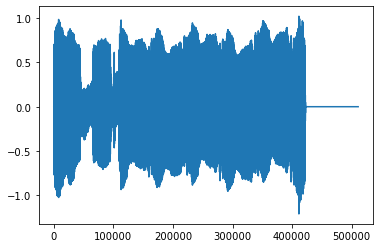

In [60]:
plt.plot(sequence.synth.returnSignal.detach())

In [ ]:
#torch.save(vb.crfAi.state_dict(), "CrossfadeWeights.dat")

In [ ]:
"""model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()"""